In [107]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from optimizers.simulations.order import simulate_from_order_func
from optimizers.utils._utils import get_csv_data
from optimizers.utils.cross_validators import vbt_cv_sliding_constructor
from optimizers.pipes.pipe import SQLPipe

load_dotenv()

USER = os.getenv('psql_username')
PASS = os.getenv('psql_password')
DATABASE = 'crypto'
SCHEMA = 'kucoin'

pipe = SQLPipe(SCHEMA, DATABASE, USER, PASS)

In [108]:
assets = ['FIL-USDT', 'CAKE-USDT']
slicer = 0 # Slice off first few months of trading to reduce early volatility

df = pipe.query_pairs_trading_backtest(assets)
closes = df.xs('close', level=1, axis=1)[slicer:]
opens = df.xs('open', level=1, axis=1)[slicer:]
assert closes.shape[0] > 8640, 'Less than 1 year of backtesting data present'
assert closes.shape == opens.shape, 'Open and close shape does not match'

print(f"Full data length: {closes.shape[0]}")

train_opens, opens = train_test_split(opens, test_size=0.30, train_size=0.70, shuffle=False)
train_closes, closes = train_test_split(closes, test_size=0.30, train_size=0.70, shuffle=False)
close_folds = vbt_cv_sliding_constructor(train_closes, n_splits=3)
open_folds = vbt_cv_sliding_constructor(train_opens, n_splits=3)

print(f"Test data length: {opens.shape[0]}")
print(f"Train fold length {close_folds[0].shape[0]}")

Full data length: 13766
Test data length: 4130
Train fold length 3212


In [109]:
# EOS FIL works on a CUMMLOG model but has volatility in per trade returns
# FIL THETA & LINK CHZ, BTC ZEC. BTCZEC might work, but had generalization issues
# ADA ZEC is untestable due to massive regime shift mid test set for LOG model
# Something is bizarre and wrong with the ADA ZEC data; needs review?
# BSV 1INCH 70  2.1 -2.4 1.3 5.000000e-07 0.00030 CUMMLOG <- does not work past 10bps slippage
# XLM1INCH, LTCCHZ, DGBCAKE, NEODGB, DGBDASH, GRT1INCH failed backtesting
# THETA FIL 100 1.2 -1.2 0.3 9.e-8 4.e-5 LOG seems to work
# BATANKR 303 0.7 -2.7 0.4 3.e-9 1.7e-5 LOG
# LTCCHZ works, but apparently failed to hedge (same issue as with CHZWIN)
# BNBTRX (LOG) failed
# BNBTRX CUMMLOG 615 1.9 -2.2 1.4 8e-6 0.3 <- low sharpe, but high WR. High duration. Deploy with minor alloc?
# XLM SUN / SUN XLM  does not generalize well. Low trade count, high duration
# XRM ETH DEFAULT failed (generalized, but very low trade count, poor return)
# XRM ETH log/cummlog has high duration and low trade count. Minimal return despite apparent generalization
# ASX VRA DEFAULT 20 2.0 -1.8 0.6 8e-8 1.2 <- extremely successful
# DOGE SUN failed on all models

PERIOD = 510
UPPER = 1.6
LOWER = -1.4
EXIT = 0.1
DELTA = 6e-6
VT = 7e-1
BURNIN = 500
MODEL = 'default'
HEDGE = 'beta'
SLIPPAGE = 0.0020
FREQ = "h"

In [110]:
pf = simulate_from_order_func(
    closes, opens,
    period=PERIOD,
    upper=UPPER,
    lower=LOWER,
    exit=EXIT,
    delta=DELTA,
    vt=VT,
    burnin=BURNIN,
    freq=FREQ,
    hedge=HEDGE,
    mode=MODEL,
    slippage=SLIPPAGE,
    order_size=0.10,
)

0.04353858136991624


<AxesSubplot:xlabel='time'>

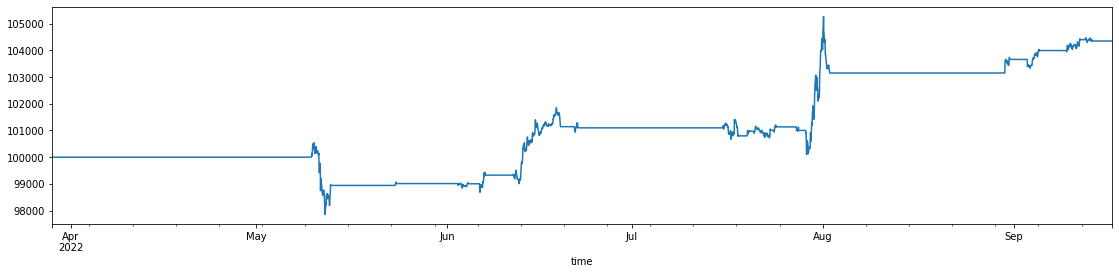

In [111]:
print(pf.total_return())
pf.value().plot(figsize=(19,4))

In [112]:
res = pf.trades.records_readable.groupby("Entry Timestamp").sum()

print(f"Total trades: {res.shape[0]}")
print(f"Executed trades: {pf.trades.records_readable.shape[0]}")
print(f"Profit Ratio: {res.PnL[res.PnL > 0].mean() / np.abs(res.PnL[res.PnL < 0].mean()):.3f}")
print(f"Net long-short win rate: {res.PnL[res.PnL > 0].shape[0] / res.shape[0] * 100:.2f}%")
print(f"Median trade profit: {res.PnL.median():.2f}")
print(f"Mean trade profit: {res.PnL.mean():.2f}")
print(f"STD of trade profit: {res.PnL.std():.2f}")
print(f"Sharpe ratio: {pf.sharpe_ratio():.4f}")

Total trades: 17
Executed trades: 34
Profit Ratio: 2.038
Net long-short win rate: 64.71%
Median trade profit: 125.55
Mean trade profit: 256.11
STD of trade profit: 735.66
Sharpe ratio: 1.9538


<AxesSubplot:xlabel='Entry Timestamp'>

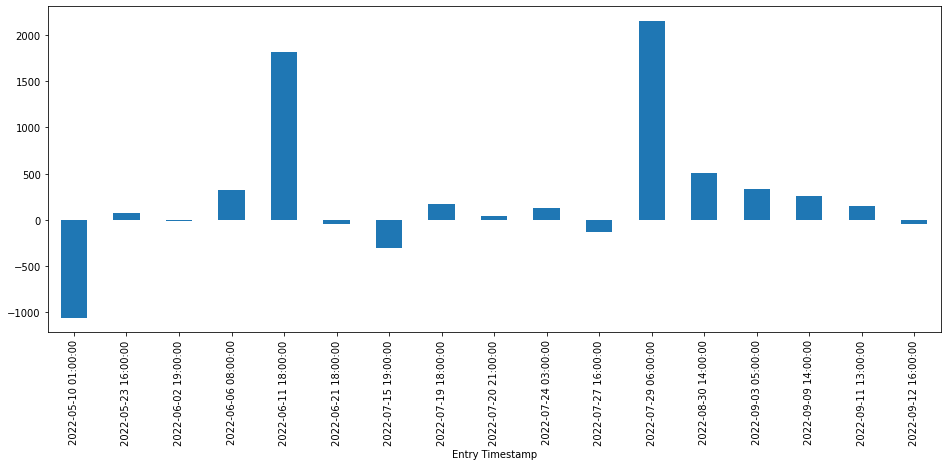

In [113]:
res.PnL.plot(kind="bar", figsize=(16,6))